# 다음에 볼 영화 예측하기 - Movielens 영화 SBR

## 목차
- 1. 프로젝트 개요
- 2. 데이터의 전처리
    - 2.1 Data Load
    - 2.2 SessionId
    - 2.3 Session Length
    - 2.4 Session Time
    - 2.5 Data Cleansing
    - 2.6 Train/Valid/Test Split
- 3. 미니 배치의 구성
    - 3.1 Session Dataset
    - 3.2 Session Data Loader
- 4. 모델 구성
    - 4.1 Evaluation Metric
    - 4.2 Model Architecture
- 5. 모델 학습
- 6. 모델 테스트

## 프로젝트 개요
### **1. Session-Based Recommendation**
- **"Session-Based Recommendation"**은 말 그대로 세션 데이터를 기반으로 **유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천**
    - Session이란 앞에서 살펴보았듯이 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하며, 서버 쪽에 저장됨
- 유저의 행동 데이터들은 유저 측 브라우저를 통해 쿠키의 형태로 저장되는데 쿠키는 세션과 상호작용하면서 정보를 주고 받음
- 여기에서는 세션을 **브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터**와 같은 의미로 사용
- 자세한 내용은 참고자료를 확인
- [쿠키, 세션, 캐시가 뭔가요?](https://www.youtube.com/watch?v=OpoVuwxGRDI&ab_channel=%EC%96%84%ED%8C%8D%ED%95%9C%EC%BD%94%EB%94%A9%EC%82%AC%EC%A0%84)
    - Cookie: 사이트를 이용하고 방문할 때 브라우저에 저장되는 내용들. 유저가 갖고 있는 정보들
    - 한계? 유저가 임의로 고치거나 지울 수 있고 남이 훔쳐볼 수 있음. 민감하거나 중요한 정보의 경우 불안함
    - Session: 사용자가 다른 누군가에게 노출되어서는 안 되는, 서비스 제공자가 직접 관리해야 할 정보들은 세션으로 서버 안에서 다뤄짐
    - Cache: 웹 뿐만 아니라 컴퓨터의 메모리 부분이나 안드로이드 등 다양한 곳에서 쓰임. 공통적인 의미로, 가져오는데 비용이 드는 데이터를 한 번 가져온 뒤에는 임시로 저장해두는 것. 이미지 등의 정보를 불러올 때, 데이터 사용량도 발생하고 시간도 들기 때문에 사용자가 여러 번 방문할 법한 사이트에서는 1번 받아온 데이터를 사용자의 컴퓨터 또는 중간 역할을 하는 서버에 저장해두는 것

- 'Movielens 1M Dataset'을 기반으로, Session based Recommendation 시스템을 제작해 보기
![cmd2.png](./images/cmd2.png)

In [1]:
# 필요 모듈 import
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 설명(Readme) 읽어 보기
import os
f = open(os.getenv('HOME') + '/aiffel/yoochoose/data/README', 'r')
while True:
    line = f.readline()
    if not line:break
    print(line)
f.close()

SUMMARY




These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 

made by 6,040 MovieLens users who joined MovieLens in 2000.



USAGE LICENSE




Neither the University of Minnesota nor any of the researchers

involved can guarantee the correctness of the data, its suitability

for any particular purpose, or the validity of results based on the

use of the data set.  The data set may be used for any research

purposes under the following conditions:



     * The user may not state or imply any endorsement from the

       University of Minnesota or the GroupLens Research Group.



     * The user must acknowledge the use of the data set in

       publications resulting from the use of the data set

       (see below for citation information).



     * The user may not redistribute the data without separate

       permission.



     * The user may not use this information for any commercial or

       revenue-bearing purposes without first obtaining permi

- 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있음. 그래서 이번에는 UserID가 SessionID 역할을 해야 함
- Rating 정보가 포함되어 있음. 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있음. 하지만, 직전에 봤던 영화가 마음에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있음. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 함
- Time 항목에는 UTC Time이 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있음

- 데이터 설명을 읽어보면 몇 가지 주목할만한 점이 있음
    - 1. 유저에 대한 정보를 전혀 알 수 없음(성별, 나이, 장소, 마지막 접속 날짜, 이전 영화 시청 내역 등등)
    - 2. 영화에 대한 정보도 전혀 알 수 없음(실제로 어떤 영화인지, 평점이나 , 가격) <br>


- 이와 달리 유저에 대한 정보를 알 수 있는 경우는 보통 **Sequential Recommendation**라고 구별해서 부르기도 함
- 유저와 아이템의 추가 정보를 Sequential Recommendation 모델에 적용하는 분야는 **Context-Aware**라는 키워드로 활발히 연구되고 있음
- 또한, E-Commerce 데이터의 경우 다음과 같은 특징을 갖음
    - 1. 비로그인 상태로 탐색하는 유저가 많음
    - 2. 로그인 상태로 탐색한다고 할지라도 접속할 때 마다 탐색하는 의도가 뚜렷하게 다름
- 즉, 마우스를 사야겠다고 마음머고 탐색한 이력이 칫솔을 사야겠다 생각하고 탐색하는 경우에 도움이 되지 않음

## 2. 데이터의 전처리
- 위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행
- 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의

### 2-1. Data Load
- 데이터를 불러와 살펴보고 주요 통계치들 살펴보기
- pathlib 라이브러리에 대한 내용은 [이쪽](https://brownbears.tistory.com/415#:~:text=pathlib%20%EC%84%A4%EB%AA%85,%EB%A1%9C%20%EB%8B%A4%EB%A3%A8%EC%9E%90%EB%8A%94%20%EA%B2%83%EC%9E%85%EB%8B%88%EB%8B%A4.&amp;text=pathlib%EC%9D%80%20%EC%8A%AC%EB%9E%98%EC%8B%9C(/)%EA%B0%80,%EC%A7%81%EA%B4%80%EC%A0%81%EC%9C%BC%EB%A1%9C%20%EC%9D%B4%ED%95%B4%ED%95%A0%20%EC%88%98%20%EC%9E%88%EC%8A%B5%EB%8B%88%EB%8B%A4.)을 참고

In [3]:
data_path = Path(os.getenv('HOME') + '/aiffel/yoochoose/data')
train_path = data_path / 'ratings.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/ratings.dat')

In [4]:
def load_data(data_path: Path, nrows = None):
    data = pd.read_csv(data_path, sep = '::', header = None, usecols = [0, 1, 2, 3],
                       dtype = {0: np.int32, 1: np.int32, 2:np.int32}, nrows = nrows)
    data.columns = ['UserId', 'MovieId', 'Rating', 'Time']
    return data

In [5]:
# 시간이 좀 걸릴 수 있음
# 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의
data = load_data(train_path, None)
# data를 id와 시간 순서로 정렬
data.sort_values(['UserId', 'Time'], inplace = True)
data

,UserId,MovieId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [6]:
data['UserId'].nunique(), data['MovieId'].nunique(), data['Time'].nunique()

(6040, 3706, 458455)

- UserId의 개수가 6,040개, 영화의 개수가 3,706개, Time의 개수가 458,455개

### 2.2 SessionId

- Session 단위를 어떻게 해석할지 설정해야 함
- Session의 경우, 여러 유저가 여러 번 접속한 고유한 기록이므로 UserId와 Time을 모두 고려해 Session으로 설정

In [7]:
# (UserId, Time)로 하나의 Session 지정
df = data.groupby(['UserId', 'Time'])['MovieId'].count().reset_index()
df.reset_index(inplace = True)
df

,index,UserId,Time,MovieId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [8]:
# Session 컬럼 추가
data = pd.merge(data, df, on = ['UserId', 'Time'])
data.drop(columns = 'MovieId_y', inplace = True)
data.columns = ['UserId', 'MovieId', 'Rating', 'Time', 'SessionId']
data

,UserId,MovieId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


### 2.3 Session Length
- 각 세션별로 대략 몇 개의 영화를 평가했는지 살펴보기

In [9]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

- 'session_length'란 같은 'SessionId'를 공유하는 데이터 row의 개수 의미
- 여기서 'SessionId'란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자
- 로그인하지 않았기 때문에 이 사용자가 누군지는 알 수 없어도, 최소한 특정 사용자의 행동을 'SessionId' 기준으로 모아서 분류해낼 수는 있음
- 따라서 여기서 'session_length'란 해당 세션의 사용자가 그 세션 동안 몇번의 액션을 취했는지(몇개의 영화를 평가했는지)의 의미가 됨

In [10]:
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

In [11]:
session_length.min(), session_length.max()

(1, 30)

In [12]:
session_length.quantile(0.999)

10.0

- 각 세션의 길이는 보통 2 정도
- 온라인에서 영화를 평가할 때를 생각해보면 이 수치가 그럴듯하게 느껴짐
- 99.9% 세션은 길이가 10이하
- 길이가 가장 긴 session은 30
- 하나를 잡고 살펴보기

In [13]:
long_session = session_length[session_length ==30].index[0]
data[data['SessionId']==long_session]

,UserId,MovieId,Rating,Time,SessionId
112347,731,3044,4,975528402,55117
112348,731,1455,3,975528402,55117
112349,731,1639,5,975528402,55117
112350,731,3244,4,975528402,55117
112351,731,1656,2,975528402,55117
112352,731,3426,4,975528402,55117
112353,731,1829,2,975528402,55117
112354,731,2675,4,975528402,55117
112355,731,802,3,975528402,55117
112356,731,803,5,975528402,55117


- 동일한 시간(975528402)에 30개의 영화에 대한 평가를 진행
- 유저들의 서비스 이용행태는 다양하기 때문에 데이터 전처리를 어떻게 할지는 모델을 만드는 사람이 판단해야 함
- e.g) 어떤 영화의 경우 1분 내에 20명이 10점을 주고 나갈 수도 있음. 영화 평점을 조작하고 있는 건 아닐까?
- 너무 긴 세션을 제거할 수도 있고 포함시킬 수도 있음
- 어떻게 하면 좋을지 판단해보기
- 세션 길이에 대한 감을 더 잘 파악하기 위해 시각화
- 아래 코드는 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것

In [14]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

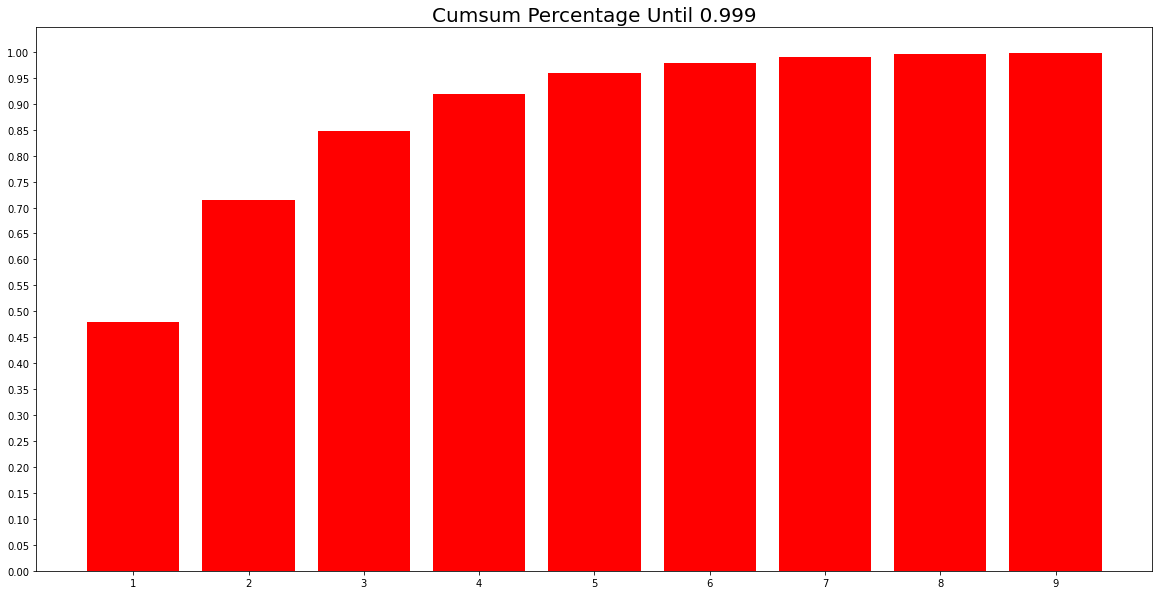

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 10))
plt.bar(x = length_percent_cumsum_999.index,
        height = length_percent_cumsum_999, color = 'red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size = 20)
plt.show()

### 2.4 Session Time

- 어떤 유자가 아이폰 구매하려고 함. 2020년 5월에는 아이폰 SE2를 구매하려는 사람 많을 것
- 그러나 그로부터 몇달 후면 아이폰 12의 구매량이 엄청나게 증가하게 될 것
- 영화나 드라마 역시 마찬가지. 유저들의 소비 패턴은 금방금방 변함
- 이런 이유 때문에 추천시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요. 이번에는 데이터가 발생한 시간에 대해 알아보기

- 다루려는 데이터의 시간 관련 정보 확인해 보기
    - Time 항목에는 UTC Time가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어있음. 이는 보기 편하게 datetime 형식으로 바꿀 것

In [17]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

956703932
1046454590


In [21]:
import datetime as dt
print(dt.datetime.utcfromtimestamp(oldest).strftime('%Y-%m-%d %H:%M:%S'))
print(dt.datetime.utcfromtimestamp(latest).strftime('%Y-%m-%d %H:%M:%S'))

2000-04-25 23:05:32
2003-02-28 17:49:50


- 데이터 설명대로 2000년 4월부터 2003년 2월까지 약 2년 8개월치 데이터가 있음

In [22]:
type(latest)

numpy.int64

In [23]:
# 최근 3년간의 데이터 수
print(len(data[data['Time'] > latest - (86400*365*3)]))
# 최근 2년간의 데이터 수
print(len(data[data['Time'] > latest - (86400*365*2)]))
# 최근 1년간의 데이터 수
print(len(data[data['Time'] > latest - (86400*365*1)]))

1000209
69349
21704


In [24]:
# 최종 날짜로부터 3년 이전 날짜 구하기
years_ago = latest - (86400*365*3)
# 방금 구한 날짜 이후의 데이터만 모으기
data = data[data['Time'] > years_ago]
data

,UserId,MovieId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


### 2.5 Data Cleansing

- 직전에 봤던 영화가 마음에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있음
- Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 함

In [25]:
print(len(data[data['Rating'] >= 1]))
print(len(data[data['Rating'] >= 2]))
print(len(data[data['Rating'] >= 3]))

1000209
944035
836478


In [26]:
data

,UserId,MovieId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


### 2.6 Train/Valid/Test Split

- 모델 평가를 위해 Valid Set과 Test Set 만들어보기
- 3개월치 데이터에서 마지막 100일을 test set, 그 이전 100일을 validation set으로 나누기

In [32]:
def split_by_date(data: pd.DataFrame, n_days:int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (86400 * n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (86400 * n_days)].index
    
    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['MovieId'].isin(before_date['MovieId'])]
    return before_date, after_date

In [33]:
tr, test = split_by_date(data, n_days = 100)
tr, val = split_by_date(tr, n_days = 100)

In [35]:
# data에 대한 정보 살펴보기
def stats_info(data: pd.DataFrame, status:str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Movies: {data["MovieId"].nunique()}\n'
          f'\t First Time: {data["Time"].min()}\n'
          f'\t Last Time: {data["Time"].max()}\n')

In [36]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 989923
	 Sessions: 463931
	 Movies: 3702
	 First Time: 956703932
	 Last Time: 1029160409

* valid Set Stats Info
	 Events: 5209
	 Sessions: 3627
	 Movies: 1949
	 First Time: 1029199206
	 Last Time: 1037810320

* test Set Stats Info
	 Events: 5073
	 Sessions: 3601
	 Movies: 1893
	 First Time: 1037824202
	 Last Time: 1046454590



In [38]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id: index for index, item_id in enumerate(tr['MovieId'].unique())}

def indexing(df, id2idx):
    # id2idx에 없는 아이템은 모르는 값(-1) 처리 해주기
    df['Movie_idx'] = df['MovieId'].map(lambda x:id2idx.get(x, -1))
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

- 이제 데이터 준비 마쳤음
- 데이터를 저장한 다음, data pipeline을 구축하는 단계로 넘어가기

In [39]:
save_path = data_path / 'processed'
save_path.mkdir(parents = True, exist_ok = True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 3. 미니 배치의 구성
- 데이터셋과 미니 배치를 구성해보기
- Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성
- 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있음

- 사용할 모델은 2016년 ICLR에서 공개된 [SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWEORKS](https://arxiv.org/pdf/1511.06939v4.pdf)
- Session Date에서는 처음으로 RNN 계열 모델을 적용하여 발표했음
- 모델 구조는 아래 그림처럼 간단함
- 여러 RNN 계열의 모델(e.g LSTM)이 있겠지만, 실험해본 결과 GRU의 성능이 제일 좋았음
- 또한 Embedding Layer를 사용하지 않았을 때가 사용했을 때보다 성능이 좋았다고 함
- 이번 노드에서도 Embedding Layer를 사용하지 않고 One-hot Encoding만 사용할 예정
![GRU.png](./images/GRU.png)

### **Session-Parallel Mini-Batches**:
- 위에서 보았듯이 Session의 길이는 매우 짧은 것들이 대부분
- 그러나 매우 긴 것들도 있음
- 이 세션들은 데이터 샘플 하나로 보고 mini-batch를 구성하여 input으로 넣는다면 길이가 젱ㄹ 긴 세션의 연산이 끝날 때까지 짧은 세션들이 기다려야 함
![session.png](./images/session.png)
- 위 그림에서 Session 1, 2, 3을 하나의 mini-batch로 만든다면, 이 미니배치의 연산은 Session 3의 연산이 끝나야 끝나는 식
- 논문의 저자는 대신 Session-Parallel Mini-Batches를 제안
- 이럼처럼 Session이 끝날 때까지 기다리지 않고 병렬적으로 계산하자는 뜻
- 아래 그램에서 session2가 끝나면 session4가 시작하는 방식
- 이렇게 구성했을 때, Mini-Batch의 shape은 (3, 1, 1)이 되고 RNN cell의 state가 1개로만 이루어짐
- 또한, Tensorflow 기준으로 RNN을 만들 때 stateful = True 옵션을 사용하고 2처럼 세션이 끝나면 state를 0으로 만들어줌
- [RNN API 보기](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN)
- 뒷부분에서 이 부분에 대한 코딩을 어떻게 했는지 살펴볼 예정
![minibatch.png](./images/minibatch.png)

### 3.1 Sesion Dataset

In [40]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""
    
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        # indexing to SessionId
        self.session_idx = np.arange(self.df['SessionId'].nunique())
        
    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype = np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

- train 데이터로 'SessioDataset' 객체를 만들고 인스턴스 변수들을 살펴보았음
- 'click_offests' 변수는 각 세션이 시작된 인덱스 담고 있음
- 'session_idx' 변수는 각 세션을 인덱싱한 'np.array'

In [41]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,MovieId,Rating,Time,SessionId,Movie_idx
0,1,3186,4,978300019,0,0
1,1,1270,5,978300055,1,1
2,1,1721,4,978300055,1,2
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,4
5,1,1836,5,978300172,3,5
6,1,3408,4,978300275,4,6
7,1,2804,5,978300719,5,7
8,1,1207,4,978300719,5,8
9,1,1193,5,978300760,6,9


In [42]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 989921, 989922, 989923], dtype=int32)

In [43]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 463928, 463929, 463930])

### 3.2 Session Data Loader
- 파이썬 문법 중 iterator, generator에 대한 추가적인 정보가 필요하면 [자료](https://dojang.io/mod/page/view.php?id=2405) 먼저 살펴보기
- 'SessionDataset' 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스 만들기
- '__iter__' 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 'yield'
- mask는 후에 RNN Cell State를 초기화 하는데 사용할 것

In [44]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""
    
    def __init__(self, dataset:SessionDataset, batch_size = 50):
        self.dataset = dataset
        self.batch_size = batch_size
        
    def __iter__(self):
        """Returns the iterator for producing session-parallel training mini-batches
        Yields:
            input (B,): Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated"""
        
        # initialize 메소드에서 확인
        start, end, mask, last_session, finished = self.initialize()
        """
        start: Index Where Session Start
        end: Index Where Session End
        mask: Indicator for the sessions to be terminated
        """
        
        while not finished:
            # Shortest Length Among Sessions
            min_len = (end - start).min() - 1
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['Movie_idx'].values[start + i]
                target = self.dataset.df['Movie_idx'].values[start + i + 1]
                yield inp, target, mask
                
            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)
            
    def initialize(self):
        # 첫 배치에 사용할 세션 Index를 가져옴
        first_iters = np.arange(self.batch_size)
        # 마지막으로 다루고 있는 세션 Index를 저장해둠
        last_session = self.batch_size - 1
        # data 상에서 session이 시작된 위치 가져옴
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]
        # session이 끝난 위치 바로 다음 위치 가져옴
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]
        # session의 모든 아이템을 다 돌은 경우, mask에 추가해줄 것
        mask = np.array([])
        # data를 전부 돌았는지 기록하기 위한 변수
        finished = False
        return start, end, mask, last_session, finished
    
    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        # 다음 배치 데이터를 생성하기 위해 상태를 update
        
        # __iter__에서 min_len만큼 for문을 돌았으므로 start를 min_len만큼 더해줌
        start += min_len
        mask = np.arange(self.batch_size)[(end - start) == 1]
        # end는 다음 세션이 시작되는 위치인데 start와 1칸 차이난다는 것은 session이 끝난다는 뜻. mask에 기록
        
        # mask에 추가된 세션 개수만큼 새로운 세션 돌것
        for i, idx in enumerate(mask, start = 1):
            new_session = last_session + i
            # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것
            if new_session > self.dataset.session_idx[-1]:
                finished = True
                break
            # update the next starting/ending point
            # 종료된 세션 대신 새로운 세션의 시작점 기록
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]
        
        # 마지막 세션의 위치 기록해둠
        last_session += len(mask)
        return start, end, mask, last_session, finished

In [45]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size = 4)
tr_dataset.df.head(15)

,UserId,MovieId,Rating,Time,SessionId,Movie_idx
0,1,3186,4,978300019,0,0
1,1,1270,5,978300055,1,1
2,1,1721,4,978300055,1,2
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,4
5,1,1836,5,978300172,3,5
6,1,3408,4,978300275,4,6
7,1,2804,5,978300719,5,7
8,1,1207,4,978300719,5,8
9,1,1193,5,978300760,6,9


In [46]:
iter_ex = iter(tr_data_loader)

- 아래 셀을 반복 실행하면 'next'가 계속 다음 데이터 만듬
- input, output, mask의 감을 잡아 보기

In [47]:
inputs, labels, mask = next(iter_ex)
print(f'Model Input Item Idx are: {inputs}')
print(f'Label Item Idx are: {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are: [19  1  7  9]
Label Item Idx are:       [20  2  8 10]
Previous Masked Input Idx are [0]


## 4. 모델 구성
- 다양하게 모델 구조를 시도해보기

### 4.1 Evaluation Metric
- 모델 성능 평가를 위한 지표 보기
- 모델 성능에 대한 지표로 precision, recall이 있음
- Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/구매한 n개의 아이템이 많아야 좋음
- 이 때문에 recall의 개념을 확장한 'recall@k' 지표, precision의 개념을 확장한 'Mean Average Precision@k' 지표 등을 사용함
- 추천에서는 몇 번째로 맞추느냐도 중요
- 구글에서 검색했을 때 1 페이지에 원하는 결과가 나오지 않고, 2페이지에 나온다면 유저 반응이 크게 떨어질 것
- 따라서 순서에 민감한 지표인 'MRR', 'NDCG' 같은 지표도 사용
- 이번 자료에서는 'MRR'과 'Recall@k'를 사용할 예정
- 'MRR'은 정답 아이템이 나온 순번의 역수 값
- 따라서 정답 아이템이 추천 결과 앞쪽순번에 나온다면 지표가 높아질 것이고, 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것
- 'NDCG' 'MRR', 'MAP'에 대한 자세한 설명은 [링크](https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832)를 확인

In [48]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0
    
def recall_k(pred, truth: int, k:int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 4.2 Model Architecure
- 스텝 3에서 소개한 모델 구조 구현
- 모델 구조가 간단한 편이므로 Functional하게 모델 만들기

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [50]:
def create_model(args):
    inputs = Input(batch_shape = (args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful = True, return_state = True, name = 'GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation = 'softmax')(dropout)
    model = Model(inputs = inputs, outputs = [predictions])
    model.compile(loss = categorical_crossentropy, optimizer = Adam(args.lr), metrics = ['accuracy'])
    model.summary()
    return model

In [51]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['MovieId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k
        
args = Args(tr, val, test, batch_size = 128, hsz = 50, drop_rate = 0.1, lr = 0.001, epochs = 10, k = 20)

In [52]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3702)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    563100    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3702)               188802    
Total params: 751,902
Trainable params: 751,902
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 학습
- 지금까지 준비한 데이터셋과 모델을 통해 학습 진행
- 학습은 총 10epoch 진행
- 배치 사이즈나 epoch 등의 설정은 위의 'args'에서 관리하므로 진행전 값을 확인해보기
- 다양한 하이퍼파라미터를 변경해 보며 검증해보기
- Recall, MRR 등의 개념들도 함께 관리될 수 있도록 구성

In [54]:
# train 셋으로 학습하면서 valid 셋으로 검증
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            # 종료된 session은 hidden_state를 초기화. 아래 메서드에서 확인
            reset_hidden_states(model, mask)  

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        # valid set에 대해 검증
        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    # model에서 gru layer를 가져옴
    gru_layer = model.get_layer(name='GRU')
    # gru_layer의 parameter를 가져옴
    hidden_states = gru_layer.states[0].numpy()  
    # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
    for elt in mask:
        # parameter를 초기화
        hidden_states[elt, :] = 0  
    gru_layer.reset_states(states=hidden_states)


# valid셋과 test셋을 평가하는 코드
# train과 거의 같지만 mrr, recall을 구하는 라인 있음
def get_metrics(data, model, args, k: int):  
                                             
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        # softmax 값이 큰 순서대로 sorting힘
        pred_arg = tf.argsort(pred, direction='DESCENDING')  

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [55]:
# 학습 시간이 다소 오래 소요됨(예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.74] 

	 - Recall@20 epoch 1: 0.125710
	 - MRR@20    epoch 1: 0.041013



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=6.46]

	 - Recall@20 epoch 2: 0.171875
	 - MRR@20    epoch 2: 0.060423



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.07] 

	 - Recall@20 epoch 3: 0.186790
	 - MRR@20    epoch 3: 0.066522



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0781, train_loss=6.36]

	 - Recall@20 epoch 4: 0.191761
	 - MRR@20    epoch 4: 0.068899



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0781, train_loss=6.36]

	 - Recall@20 epoch 5: 0.191051
	 - MRR@20    epoch 5: 0.071372



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0781, train_loss=6.28]

	 - Recall@20 epoch 6: 0.193182
	 - MRR@20    epoch 6: 0.072703



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0859, train_loss=6.21] 

	 - Recall@20 epoch 7: 0.195312
	 - MRR@20    epoch 7: 0.073107



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0781, train_loss=6.21]

	 - Recall@20 epoch 8: 0.197443
	 - MRR@20    epoch 8: 0.073486



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=6.13] 

	 - Recall@20 epoch 9: 0.195312
	 - MRR@20    epoch 9: 0.073079



Evaluation:  92%|█████████▏| 11/12 [00:08<00:00,  1.37it/s]

	 - Recall@20 epoch 10: 0.198153
	 - MRR@20    epoch 10: 0.071011



## 6. 모델 테스트
- 미리 구성한 테스트셋을 바탕으로 Recall, MRR을 확인해 보기

In [57]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  91%|█████████ | 10/11 [00:06<00:00,  1.44it/s]

	 - Recall@20: 0.268750
	 - MRR@20: 0.104594

